In [1]:
import re
import pandas as pd
from collections import defaultdict
from time import time

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter

import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from gensim import utils
import gensim.parsing.preprocessing as gsp
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import os

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from wordcloud import WordCloud, ImageColorGenerator


import multiprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/JohanNg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/JohanNg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv('combined.csv')

In [3]:
df['source'].value_counts()

Reuters            11150
CNBC News           9703
Gateway Pundit      8615
Others              6834
Washington Post     3047
CNN                 1946
New York Times      1010
Huffington Post      424
InfoWars             397
LA Times             295
Name: source, dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43421 entries, 0 to 43420
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   43421 non-null  object
 1   source  43421 non-null  object
dtypes: object(2)
memory usage: 678.6+ KB


## Feature Engineering

In [5]:
stop_words = set(stopwords.words('english'))

In [6]:
%%time
#Getting character count
df['char_count'] = df['title'].apply(len)

#Getting word count
df['word_count'] = df['title'].apply(lambda x: len(x.split()))

#Getting punctuation count
count = lambda l1,l2: sum([1 for x in l1 if x in l2])
df['punctuation_count'] = df['title'].apply(lambda x: count(x, string.punctuation))

#Getting Upper Case Count
df['upper_case_count'] = df['title'].apply(lambda x: sum(1 for a in x if a.isupper()))

#Getting Title word Count
df['title_word_count'] = df['title'].apply(lambda x: len([a for a in x.split() if a.istitle()]))

#Getting Stop Word Count
df['stopword_count'] = df['title'].apply(lambda x: len([a for a in x.split() if a.lower() in stop_words]))

CPU times: user 519 ms, sys: 2.93 ms, total: 522 ms
Wall time: 522 ms


In [7]:
df.head()

,title,source,char_count,word_count,punctuation_count,upper_case_count,title_word_count,stopword_count
0,Former State Department aide arrested in conne...,CNBC News,69,10,0,4,4,2
1,China proposes changes to Hong Kong’s electora...,CNBC News,54,8,0,3,2,1
2,Biden called off strike against second target ...,CNBC News,96,15,1,2,2,4
3,"U.S. imposes trade sanctions on Myanmar, calls...",CNBC News,88,16,6,4,3,4
4,Frozen fund for Jeffrey Epstein victims needs ...,CNBC News,91,16,4,6,4,3


In [8]:
df.describe()

,char_count,word_count,punctuation_count,upper_case_count,title_word_count,stopword_count
count,43421.000000,43421.000000,43421.000000,43421.000000,43421.00000,43421.000000
mean,82.399922,12.972433,1.697704,11.991433,5.76030,3.107736
std,24.596860,4.045595,1.543101,13.623361,4.70309,1.966333
min,13.000000,1.000000,0.000000,0.000000,0.00000,0.000000
25%,65.000000,10.000000,0.000000,3.000000,2.00000,2.000000
50%,78.000000,12.000000,1.000000,5.000000,4.00000,3.000000
75%,95.000000,15.000000,3.000000,17.000000,9.00000,4.000000
max,286.000000,42.000000,26.000000,137.000000,31.00000,18.000000


In [9]:
#Text Preprocessing

lemma = WordNetLemmatizer()

def text_processing(text):
    
    #Remove extra spaces
    text = re.sub(r's+','',text)
    
    #Remove numbers and punctuation
    text = re.sub(r'[^a-zA-Z]',' ',text)
    
    #Convert all characters into lower_case
    text = str(text).lower()
    
    #Tokenize
    text = word_tokenize(text)
    
    #Remove stop words
    text = [item for item in text if item not in stop_words]
    
    #Lemmatize
    text = [lemma.lemmatize(word = w, pos = 'v') for w in text]
    
    #Remove words with length <=2
    text = [i for i in text if len(i) > 2]
    
    #convert list to string
    text = " ".join(text)
    
    return text

In [10]:
%%time

df['clean'] = df['title'].apply(text_processing)

CPU times: user 5.77 s, sys: 61.3 ms, total: 5.83 s
Wall time: 5.84 s


In [11]:
sent = [row.split() for row in df['clean']]

In [118]:
sentences

In [12]:
df_title = df[['title','clean']]

In [13]:
df_title.head(10)

,title,clean
0,Former State Department aide arrested in conne...,former state department aide arreted connectio...
1,China proposes changes to Hong Kong’s electora...,china propoe change hong kong electoral ytem
2,Biden called off strike against second target ...,biden call trike againt econd target syria avo...
3,"U.S. imposes trade sanctions on Myanmar, calls...",impoe trade anction myanmar call china help en...
4,Frozen fund for Jeffrey Epstein victims needs ...,freeze fund jeffrey eptein victim need ale cri...
5,"The expanded $3,000 child tax credit would hel...",expand child tax credit would help million kid...
6,House won’t vote on Biden’s comprehensive immi...,houe vote biden comprehenive immigration plan ...
7,China has banned Taiwan’s pineapples. Taiwan s...,china ban taiwan pineapple taiwan fair play
8,D.C. National Guard chief: Pentagon took 3 hou...,national guard chief pentagon take hour greenl...
9,Few Democratic governors speak up on Cuomo sex...,democratic governor peak cuomo exual harament ...


In [14]:
phrases = Phrases(sent, min_count = 30, progress_per = 10000)

INFO - 21:47:37: collecting all words and their counts
INFO - 21:47:37: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 21:47:37: PROGRESS: at sentence #10000, processed 90165 words and 63332 word types
INFO - 21:47:37: PROGRESS: at sentence #20000, processed 187639 words and 124736 word types
INFO - 21:47:37: PROGRESS: at sentence #30000, processed 273691 words and 169423 word types
INFO - 21:47:37: PROGRESS: at sentence #40000, processed 363912 words and 216753 word types
INFO - 21:47:38: collected 238457 word types from a corpus of 401319 words (unigram + bigrams) and 43421 sentences
INFO - 21:47:38: using 238457 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>


In [15]:
bigram = Phraser(phrases)

INFO - 21:47:38: source_vocab length 238457
INFO - 21:47:39: Phraser built with 268 phrasegrams


In [16]:
#Transform Corpus based on bigrams detected

sentences = bigram[sent]

In [17]:
#Creating a word freqeuncy dictionary

word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

17704

In [18]:
#Checking most frequent words

sorted(word_freq, key=word_freq.get, reverse=True)[:10]


['trump',
 'video',
 'obama',
 'democrat',
 'biden',
 'republican',
 'preident',
 'new',
 'white_houe',
 'election']

In [19]:
df.to_csv('cleaned.csv', index = False)

In [20]:
#Count Vectors as features
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df['clean'])

clean_count = count_vect.transform(df['clean'])


In [21]:
#TFID Vectors as Features

#Getting word level tfid
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df['clean'])

clean_tfidf = tfidf_vect.transform(df['clean'])

## Word Embedding

In [22]:
cores = multiprocessing.cpu_count()
cores

8

In [23]:
#Word2Vec Parameters
min_count = 20 #Ignores all word with total frequency lower than this

window = 2 #Maximum distance between Current and Predicted word within a sentence

size = 300 #Dimensionality of Word Vectors

sample = 1e-5 #The threshold for configuring which higher-frequency words are randomly downsampled

alpha= 0.020 #Initial Learning Rate

min_alpha = 0.0007 #Learning rate will linearly drop to min_alpha as training progresses 

negative = 15 #Specifies how "noisy" words should be drawn

hs = 0 #Negative sampling

sg = 1 #Skipgram

workers = cores

ns_exponent = 0.75 #Exponent used to shape negative sampling distribution

sorted_vocab = 1

In [119]:
%%time

model = Word2Vec(min_count=min_count,
                 size= size,
                 window =window, 
                 sample = sample,
                 alpha = alpha,
                 min_alpha = min_alpha,
                 negative = negative,
                 sg = sg,
                 hs = hs,
                 workers = workers,
                 ns_exponent = ns_exponent,
                 sorted_vocab = sorted_vocab)

CPU times: user 1.62 ms, sys: 10.5 ms, total: 12.2 ms
Wall time: 51.5 ms


In [25]:
t = time()

model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 21:47:41: collecting all words and their counts
INFO - 21:47:41: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 21:47:41: PROGRESS: at sentence #10000, processed 84641 words, keeping 8180 word types
INFO - 21:47:41: PROGRESS: at sentence #20000, processed 176596 words, keeping 12654 word types
INFO - 21:47:42: PROGRESS: at sentence #30000, processed 257746 words, keeping 14592 word types
INFO - 21:47:42: PROGRESS: at sentence #40000, processed 343708 words, keeping 16665 word types
INFO - 21:47:42: collected 17704 word types from a corpus of 379781 raw words and 43421 sentences
INFO - 21:47:42: Loading a fresh vocabulary
INFO - 21:47:42: effective_min_count=20 retains 3031 unique words (17% of original 17704, drops 14673)
INFO - 21:47:42: effective_min_count=20 leaves 324244 word corpus (85% of original 379781, drops 55537)
INFO - 21:47:42: deleting the raw counts dictionary of 17704 items
INFO - 21:47:42: sample=1e-05 downsamples 3031 most-common words

Time to build vocab: 0.02 mins


In [26]:
t = time()

model.train(sentences, total_examples=model.corpus_count, epochs=40, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 21:47:42: training model with 8 workers on 3031 vocabulary and 300 features, using sg=1 hs=0 sample=1e-05 negative=15 window=2
INFO - 21:47:43: worker thread finished; awaiting finish of 7 more threads
INFO - 21:47:43: worker thread finished; awaiting finish of 6 more threads
INFO - 21:47:43: worker thread finished; awaiting finish of 5 more threads
INFO - 21:47:43: worker thread finished; awaiting finish of 4 more threads
INFO - 21:47:43: worker thread finished; awaiting finish of 3 more threads
INFO - 21:47:43: worker thread finished; awaiting finish of 2 more threads
INFO - 21:47:43: worker thread finished; awaiting finish of 1 more threads
INFO - 21:47:43: worker thread finished; awaiting finish of 0 more threads
INFO - 21:47:43: EPOCH - 1 : training on 379781 raw words (57216 effective words) took 0.9s, 66601 effective words/s
INFO - 21:47:44: worker thread finished; awaiting finish of 7 more threads
INFO - 21:47:44: worker thread finished; awaiting finish of 6 more threads

INFO - 21:47:52: worker thread finished; awaiting finish of 4 more threads
INFO - 21:47:52: worker thread finished; awaiting finish of 3 more threads
INFO - 21:47:52: worker thread finished; awaiting finish of 2 more threads
INFO - 21:47:52: worker thread finished; awaiting finish of 1 more threads
INFO - 21:47:52: worker thread finished; awaiting finish of 0 more threads
INFO - 21:47:52: EPOCH - 12 : training on 379781 raw words (57533 effective words) took 0.7s, 77330 effective words/s
INFO - 21:47:52: worker thread finished; awaiting finish of 7 more threads
INFO - 21:47:52: worker thread finished; awaiting finish of 6 more threads
INFO - 21:47:52: worker thread finished; awaiting finish of 5 more threads
INFO - 21:47:52: worker thread finished; awaiting finish of 4 more threads
INFO - 21:47:52: worker thread finished; awaiting finish of 3 more threads
INFO - 21:47:52: worker thread finished; awaiting finish of 2 more threads
INFO - 21:47:52: worker thread finished; awaiting finish 

INFO - 21:48:00: worker thread finished; awaiting finish of 0 more threads
INFO - 21:48:00: EPOCH - 23 : training on 379781 raw words (57486 effective words) took 0.8s, 76464 effective words/s
INFO - 21:48:01: worker thread finished; awaiting finish of 7 more threads
INFO - 21:48:01: worker thread finished; awaiting finish of 6 more threads
INFO - 21:48:01: worker thread finished; awaiting finish of 5 more threads
INFO - 21:48:01: worker thread finished; awaiting finish of 4 more threads
INFO - 21:48:01: worker thread finished; awaiting finish of 3 more threads
INFO - 21:48:01: worker thread finished; awaiting finish of 2 more threads
INFO - 21:48:01: worker thread finished; awaiting finish of 1 more threads
INFO - 21:48:01: worker thread finished; awaiting finish of 0 more threads
INFO - 21:48:01: EPOCH - 24 : training on 379781 raw words (57605 effective words) took 0.7s, 77433 effective words/s
INFO - 21:48:02: worker thread finished; awaiting finish of 7 more threads
INFO - 21:48:0

INFO - 21:48:09: worker thread finished; awaiting finish of 5 more threads
INFO - 21:48:09: worker thread finished; awaiting finish of 4 more threads
INFO - 21:48:09: worker thread finished; awaiting finish of 3 more threads
INFO - 21:48:09: worker thread finished; awaiting finish of 2 more threads
INFO - 21:48:09: worker thread finished; awaiting finish of 1 more threads
INFO - 21:48:09: worker thread finished; awaiting finish of 0 more threads
INFO - 21:48:09: EPOCH - 35 : training on 379781 raw words (57193 effective words) took 0.7s, 76461 effective words/s
INFO - 21:48:10: worker thread finished; awaiting finish of 7 more threads
INFO - 21:48:10: worker thread finished; awaiting finish of 6 more threads
INFO - 21:48:10: worker thread finished; awaiting finish of 5 more threads
INFO - 21:48:10: worker thread finished; awaiting finish of 4 more threads
INFO - 21:48:10: worker thread finished; awaiting finish of 3 more threads
INFO - 21:48:10: worker thread finished; awaiting finish 

Time to train the model: 0.52 mins


In [27]:
if not os.path.exists('trained_models'):
    os.makedirs('trained_models')

In [28]:
model.save(os.path.join('trained_models','w2v_model.w2v'))

INFO - 21:48:13: saving Word2Vec object under trained_models/w2v_model.w2v, separately None
INFO - 21:48:13: not storing attribute vectors_norm
INFO - 21:48:13: not storing attribute cum_table
INFO - 21:48:13: saved trained_models/w2v_model.w2v


In [29]:
model.wv.most_similar(positive = ['trump'], topn = 20)

INFO - 21:48:13: precomputing L2-norms of word weight vectors


[('daca', 0.9997900724411011),
 ('unlikely', 0.9997890591621399),
 ('doubt', 0.9997875690460205),
 ('quick', 0.9997838139533997),
 ('dreamer', 0.9997826218605042),
 ('policy', 0.9997819662094116),
 ('expert', 0.9997819066047668),
 ('afety', 0.9997818470001221),
 ('biden', 0.9997815489768982),
 ('partian', 0.9997806549072266),
 ('lam', 0.999779999256134),
 ('etback', 0.9997798204421997),
 ('negotiator', 0.9997798204421997),
 ('chance', 0.9997797608375549),
 ('tueday', 0.9997797608375549),
 ('grow', 0.9997790455818176),
 ('countrie', 0.9997788071632385),
 ('puh', 0.9997786283493042),
 ('hould', 0.9997785091400146),
 ('mull', 0.9997785091400146)]

In [30]:
model.wv.most_similar(positive = ['obama'], topn = 20)

[('attempt', 0.9998533725738525),
 ('volunteer', 0.9998453855514526),
 ('list', 0.9998443126678467),
 ('nothing', 0.9998440146446228),
 ('profile', 0.999843955039978),
 ('write', 0.9998421669006348),
 ('sign', 0.9998413920402527),
 ('expose', 0.9998413324356079),
 ('liberals', 0.999841034412384),
 ('weekend', 0.9998406767845154),
 ('refugees', 0.999840259552002),
 ('reality', 0.9998401403427124),
 ('bust', 0.9998396635055542),
 ('happy', 0.9998394846916199),
 ('compare', 0.9998393058776855),
 ('naty', 0.999839186668396),
 ('communit', 0.9998390078544617),
 ('lose', 0.9998389482498169),
 ('amaze', 0.9998389482498169),
 ('wikileaks', 0.999838650226593)]

In [31]:
model.wv.most_similar(positive = ['fake'], topn = 20)

[('real', 0.9998630285263062),
 ('unbelievable', 0.999862790107727),
 ('outrage', 0.9998591542243958),
 ('nightmare', 0.9998589158058167),
 ('expoe', 0.9998579025268555),
 ('montana', 0.9998579025268555),
 ('proof', 0.9998577237129211),
 ('terror_attack', 0.9998576641082764),
 ('bust', 0.9998565316200256),
 ('admit', 0.9998562932014465),
 ('oops', 0.9998560547828674),
 ('gather', 0.9998559355735779),
 ('stand', 0.9998557567596436),
 ('community', 0.999855637550354),
 ('catholic', 0.9998555779457092),
 ('dinner', 0.9998553395271301),
 ('blast', 0.9998546838760376),
 ('strategy', 0.999854564666748),
 ('sugget', 0.9998544454574585),
 ('expose', 0.9998539686203003)]

In [32]:
model.wv.most_similar(positive = ['election'], topn = 20)

[('ramp', 0.9998634457588196),
 ('electoral_college', 0.9998505711555481),
 ('partian', 0.9998504519462585),
 ('reject', 0.999850332736969),
 ('mut', 0.9998501539230347),
 ('lam', 0.9998499155044556),
 ('mail_ballot', 0.9998496770858765),
 ('reult', 0.9998496770858765),
 ('yet', 0.9998495578765869),
 ('tranition', 0.9998488426208496),
 ('count', 0.9998487234115601),
 ('keep', 0.9998485445976257),
 ('audit', 0.9998483657836914),
 ('wiconin', 0.9998477697372437),
 ('runoff', 0.9998476505279541),
 ('defeat', 0.9998470544815063),
 ('open', 0.999846875667572),
 ('need_know', 0.9998465776443481),
 ('victory', 0.9998464584350586),
 ('health_care', 0.9998464584350586)]

In [33]:
model.wv.most_similar(positive = ['clinton'], topn = 20)

[('turn', 0.9998703598976135),
 ('must_read', 0.9998672008514404),
 ('list', 0.9998633861541748),
 ('dinner', 0.9998629689216614),
 ('reaon', 0.9998623728752136),
 ('practice', 0.9998617172241211),
 ('recent', 0.9998617172241211),
 ('aked', 0.9998611211776733),
 ('liberal_media', 0.9998608231544495),
 ('recommend', 0.9998598694801331),
 ('fundraiing', 0.9998598098754883),
 ('oops', 0.9998596906661987),
 ('converation', 0.9998582005500793),
 ('inider', 0.9998567700386047),
 ('fundraier', 0.9998559355735779),
 ('marco_rubio', 0.9998557567596436),
 ('crook_hillary', 0.9998550415039062),
 ('greatet', 0.9998548626899719),
 ('comment', 0.9998548030853271),
 ('meltdown', 0.999854564666748)]

In [34]:
model.wv.doesnt_match(['trump','obama','clinton'])

/Users/JohanNg/miniconda3/lib/python3.8/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'trump'

In [35]:
 model.wv.doesnt_match(['trump','obama','fake'])

'trump'

In [36]:
 model.wv.doesnt_match(['trump','clinton','fake'])

'trump'

In [37]:
 model.wv.doesnt_match(['trump','election','fake'])

'trump'

In [38]:
len(model.wv.vocab)

3031

In [39]:
word_matrix = model.wv.syn0

<ipython-input-39-30b59718b191>:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  word_matrix = model.wv.syn0


In [40]:
word_matrix

array([[-0.06344227, -0.18074946,  0.0112153 , ...,  0.18599388,
         0.00871696,  0.02889416],
       [-0.07046088, -0.18403624,  0.01789423, ...,  0.1896011 ,
         0.01048021,  0.03234185],
       [-0.06417909, -0.17898728,  0.01603547, ...,  0.18656214,
         0.00829202,  0.02855458],
       ...,
       [-0.07078429, -0.18366985,  0.01785871, ...,  0.1948495 ,
         0.00711999,  0.02929826],
       [-0.06503975, -0.17499016,  0.01470875, ...,  0.18246521,
         0.00796234,  0.02870959],
       [-0.0689252 , -0.18632574,  0.01434292, ...,  0.1915279 ,
         0.01194228,  0.03101786]], dtype=float32)

In [41]:
#Getting coordinates of words

df_vectors = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, word_matrix[model.wv.vocab[word].index])
            for word in model.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [42]:
df_vectors.head()

,word,x,y
0,former,-0.064927,-0.180710
1,state_department,-0.065981,-0.178640
2,aide,-0.062585,-0.179945
3,arreted,-0.069147,-0.184085
4,connection,-0.067744,-0.182707


## K-Means Clustering

In [43]:
np.std(word_matrix), np.mean(word_matrix)

(0.08987455, -0.009853462)

In [44]:
#Use standard scaler
scaled_matrix = StandardScaler().fit_transform(word_matrix)

In [45]:
np.std(scaled_matrix),np.mean(scaled_matrix)

(1.0, -2.6849292e-10)

In [46]:
X = scaled_matrix

CPU times: user 2min 54s, sys: 1min 44s, total: 4min 38s
Wall time: 44 s


Text(0, 0.5, 'Sum of squared distance')

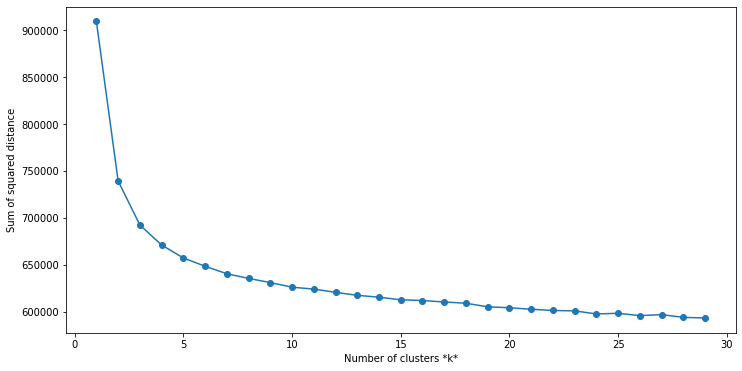

In [47]:
%%time
# Use elbow method to plot optimal k

sse = []
list_k = list(range(1, 30))

for k in list_k:
    km = KMeans(n_clusters=k, n_init = 20, random_state = 42)
    km.fit(X)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(12, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

In [48]:
from kneed import KneeLocator

In [49]:
# Use KneeLocator for more accurate k
kl = KneeLocator(range(1, 30), sse, curve="convex", direction="decreasing")

print('Optimal k = ' + str(kl.elbow))

Optimal k = 5


In [50]:
#Use K as 4 for clusters 
km_model = KMeans(n_clusters = 5,n_init = 10, max_iter = 300, random_state = 42)
km_model.fit(X)
km_groups = km_model.labels_

In [51]:
df_vectors['kmeans_cluster'] = km_groups.tolist()

In [52]:
kmeans_cluster1 = df_vectors.loc[df_vectors['kmeans_cluster'] == 0]
kmeans_cluster2 = df_vectors.loc[df_vectors['kmeans_cluster'] == 1]
kmeans_cluster3 = df_vectors.loc[df_vectors['kmeans_cluster'] == 2]
kmeans_cluster4 = df_vectors.loc[df_vectors['kmeans_cluster'] == 3]
kmeans_cluster5 = df_vectors.loc[df_vectors['kmeans_cluster'] == 4]
# kmeans_cluster6 = df_vectors.loc[df_vectors['kmeans_cluster'] == 5]
# kmeans_cluster7 = df_vectors.loc[df_vectors['kmeans_cluster'] == 6]
# kmeans_cluster8 = df_vectors.loc[df_vectors['kmeans_cluster'] == 7]
# kmeans_cluster9 = df_vectors.loc[df_vectors['kmeans_cluster'] == 8]
# kmeans_cluster10 = df_vectors.loc[df_vectors['kmeans_cluster'] == 9]
# kmeans_cluster11 = df_vectors.loc[df_vectors['kmeans_cluster'] == 10]

In [53]:
# #Getting Centers and Clusters

# centroids = km_model.cluster_centers_
# clusters = km_model.fit_predict(X)

# centroid_map = dict(zip(model.wv.index2word,clusters))

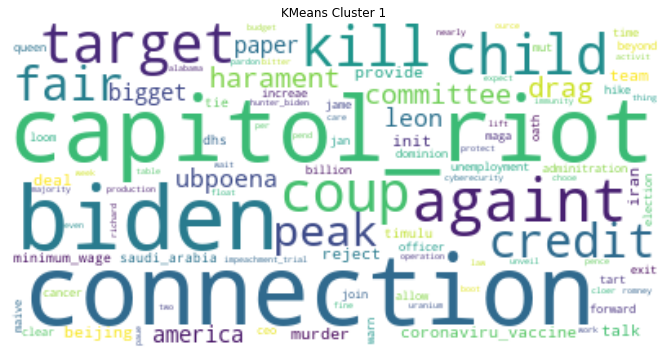

In [54]:
#Plotting wordcloud 

cloud = WordCloud(max_words = 100, background_color = 'white')
wordcloud = cloud.generate(' '.join([word for word in kmeans_cluster1['word']]))
plt.figure(figsize = (12,6))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.title('KMeans Cluster 1')
plt.axis('off')
plt.show()

In [55]:
for word in kmeans_cluster1['word']: #real
    print(word)

connection
capitol_riot
biden
againt
target
kill
coup
child
credit
fair
peak
harament
drag
committee
ubpoena
leon
america
bigget
paper
coronaviru_vaccine
team
deal
beijing
murder
iran
reject
talk
init
provide
saudi_arabia
tie
minimum_wage
timulu
dhs
unemployment
ceo
queen
forward
increae
jame
jan
time
dominion
billion
election
exit
tart
mut
beyond
warn
cancer
oath
join
officer
adminitration
hike
loom
allow
maive
clear
maga
impeachment_trial
chooe
uranium
production
even
majority
boot
expect
law
activit
pence
romney
unveil
float
ource
fine
cyberecurity
nearly
pardon
richard
alabama
per
immunity
table
lift
wait
two
week
budget
work
cloer
paue
protect
care
bitter
pend
operation
hunter_biden
thing
protet
start
ditrict
pace
latino
ruian
impeachment
argue
ign
ability
worker
political
line
aying
place
world
jordan
around
bahing
gulf
dicued
cover
agree
worry
trangender
contitutional
loyalit
overturn_election
contribution
gop_rep
optimitic
refer
wray
buted
india
celebrate
prayer
ued
mandate
pom

In [56]:
#Checking len of cluster 1
print(len(kmeans_cluster1['word']))

466


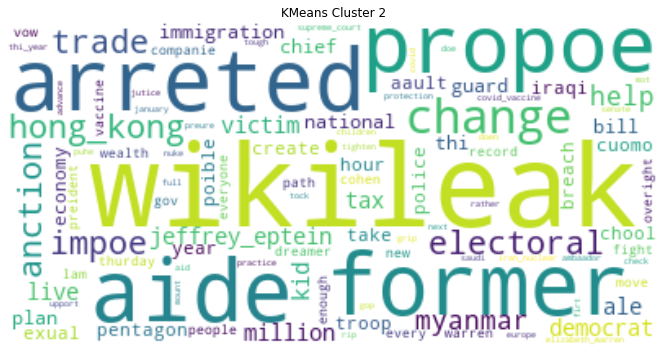

In [57]:
cloud = WordCloud(max_words = 100, background_color = 'white')
wordcloud = cloud.generate(' '.join([word for word in kmeans_cluster2['word']]))
plt.figure(figsize = (12,6))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.title('KMeans Cluster 2')
plt.axis('off')
plt.show()

In [58]:
for word in kmeans_cluster2['word']: #Fake
    print(word)

former
aide
arreted
propoe
change
hong_kong
electoral
impoe
trade
anction
myanmar
help
jeffrey_eptein
victim
ale
tax
million
kid
live
democrat
immigration
plan
thi
bill
national
guard
chief
pentagon
take
hour
troop
aault
cuomo
exual
chool
could
create
economy
year
iraqi
police
poible
breach
thurday
overight
record
warren
wealth
people
companie
path
dreamer
lam
new
vow
gov
everyone
cohen
fight
preident
move
vaccine
enough
every
supreme_court
jutice
protection
senate
check
aid
next
elizabeth_warren
rip
tock
mot
rather
saudi
upport
tough
preure
europe
practice
ambaador
doen
iran_nuclear
thi_year
mount
tighten
grip
gop
puhe
covid
january
advance
full
nuke
firt
doe
covid_vaccine
children
early
tell
congre
elf
defene
information
digital
allie
thee
criticize
launch
approve
retriction
trillion
package
foreign_policy
expert
releaed
grant
dometic
extremim
boycott
grow
pledge
agriculture
way
undertand
health
inauguration
accue
cia
plead_guilty
public
proecutor
urge
friday
drug
hold
conpiracy
reti

In [59]:
#Checking len of cluster 2
print(len(kmeans_cluster2['word']))

957


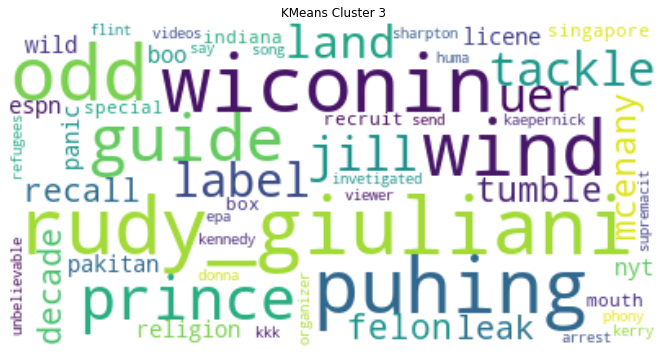

In [60]:
cloud = WordCloud(max_words = 100, background_color = 'white')
wordcloud = cloud.generate(' '.join([word for word in kmeans_cluster3['word']]))
plt.figure(figsize = (12,6))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.title('KMeans Cluster 3')
plt.axis('off')
plt.show()

In [61]:
for word in kmeans_cluster3['word']: #real
    print(word)

rudy_giuliani
wiconin
puhing
odd
wind
guide
prince
tackle
label
jill
uer
land
felon
tumble
mcenany
recall
leak
decade
religion
wild
espn
panic
licene
boo
nyt
pakitan
singapore
indiana
recruit
special
mouth
box
kaepernick
phony
epa
invetigated
sharpton
kennedy
say
kkk
send
organizer
song
donna
arrest
videos
supremacit
unbelievable
huma
refugees
viewer
kerry
flint


In [62]:
#Checking len of cluster 3
print(len(kmeans_cluster3['word']))

53


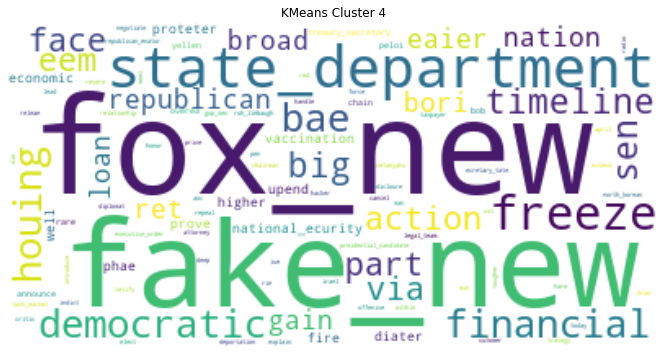

In [63]:
cloud = WordCloud(max_words = 100, background_color = 'white')
wordcloud = cloud.generate(' '.join([word for word in kmeans_cluster4['word']]))
plt.figure(figsize = (12,6))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.title('KMeans Cluster 4')
plt.axis('off')
plt.show()

In [64]:
for word in kmeans_cluster4['word']: #fake
    print(word)

state_department
freeze
democratic
bae
houing
financial
timeline
big
sen
action
face
part
via
eem
republican
nation
eaier
loan
ret
gain
broad
bori
national_ecurity
prove
proteter
diater
well
fire
economic
upend
higher
vaccination
phae
treaury_secretary
yellen
peloi
announce
overea
chain
rare
bob
preidential_candidate
deep
introduce
attorney
handle
relationhip
irael
netanyahu
ruh_limbaugh
radio
die
north_korean
hacker
hare
force
meet
explain
republican_enator
diplomat
pen
taxpayer
releae
trategy
ecretary_tate
tock_market
gop_sen
negotiate
iue
rie
within
lead
cot
dicloure
tetify
cancel
offenive
april
price
extend
executive_order
today
legal_team
critic
draw
red
honor
indict
muk
man
cutomer
aoc
tougher
revere
elect
deportation
chairman
repeal
carrier
ignal
article
rioter
apologize
donation
office
fit
smith
citizen
schumer
inurrection
chritopher
vice_preident
fox_new
cheat
emotional
coordinate
intelligence
nra
file
look
name
bail
dark
love
affair
policy
pending
lot
voter_fraud
twice
tortur

In [65]:
# Checking len of cluster 4
print(len(kmeans_cluster4['word']))

568


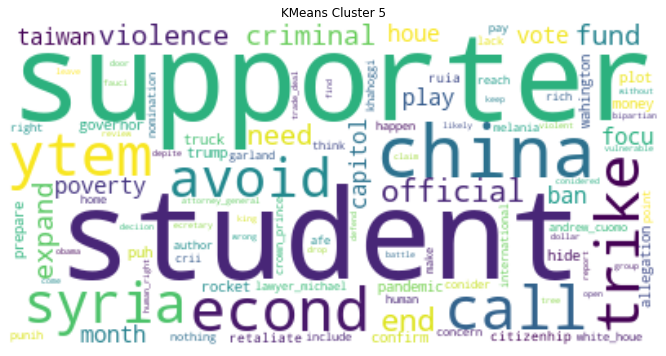

In [66]:
cloud = WordCloud(max_words = 100, background_color = 'white')
wordcloud = cloud.generate(' '.join([word for word in kmeans_cluster5['word']]))
plt.figure(figsize = (12,6))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.title('KMeans Cluster 5')
plt.axis('off')
plt.show()

In [67]:
for word in kmeans_cluster5['word']: #fake
    print(word)

china
ytem
call
trike
econd
syria
avoid
official
end
violence
fund
need
criminal
expand
would
poverty
houe
vote
month
focu
ban
taiwan
play
capitol
governor
allegation
pandemic
confirm
rocket
truck
prepare
plot
wahington
trump
hide
money
puh
citizenhip
ruia
retaliate
andrew_cuomo
author
lawyer_michael
white_houe
conider
right
include
nothing
afe
home
reach
crii
point
think
rich
pay
make
human
happen
lack
concern
international
melania
punih
crown_prince
khahoggi
garland
nomination
attorney_general
drop
defend
deciion
likely
come
fauci
review
dollar
keep
battle
find
bipartian
leave
vulnerable
obama
without
depite
tree
human_right
king
report
violent
door
open
trade_deal
ecretary
claim
wrong
conidered
group
donald_trump
probe
nominee
drink
charge
covid_relief
aim
wife
powerful
jail
expoe
fraud
unite
rule
tudent
black
raiing
corporate
hedge
miing
root
compromie
nuclear
negotiation
mike
profit
june
tariff
form
detain
american
advior
ought
rally
unity
condemn
commitment
global_warm
wave
one
b

In [68]:
#Checking len of cluster 5
print(len(kmeans_cluster5['word']))

987


In [69]:
# cloud = WordCloud(max_words = 100, background_color = 'white')
# wordcloud = cloud.generate(' '.join([word for word in kmeans_cluster6['word']]))
# plt.figure(figsize = (12,6))
# plt.imshow(wordcloud,interpolation = 'bilinear')
# plt.title('KMeans Cluster 6')
# plt.axis('off')
# plt.show()

In [70]:
# for word in kmeans_cluster6['word']:#Fake News 
#     print(word)

In [71]:
# #Checking len of cluster 6
# print(len(kmeans_cluster6['word']))

In [72]:
# cloud = WordCloud(max_words = 100, background_color = 'white')
# wordcloud = cloud.generate(' '.join([word for word in kmeans_cluster7['word']]))
# plt.figure(figsize = (12,6))
# plt.imshow(wordcloud,interpolation = 'bilinear')
# plt.title('KMeans Cluster 7')
# plt.axis('off')
# plt.show()

In [73]:
# for word in kmeans_cluster7['word']:
#     print(word)

In [74]:
#Checking len of cluster 7
# print(len(kmeans_cluster7['word']))

In [75]:
# cloud = WordCloud(max_words = 100, background_color = 'white')
# wordcloud = cloud.generate(' '.join([word for word in kmeans_cluster8['word']]))
# plt.figure(figsize = (12,6))
# plt.imshow(wordcloud,interpolation = 'bilinear')
# plt.title('KMeans Cluster 8')
# plt.axis('off')
# plt.show()

In [76]:
# for word in kmeans_cluster8['word']:
#     print(word)

In [77]:
#Checking len of cluster 8
# print(len(kmeans_cluster8['word']))

In [78]:
# cloud = WordCloud(max_words = 100, background_color = 'white')
# wordcloud = cloud.generate(' '.join([word for word in kmeans_cluster9['word']]))
# plt.figure(figsize = (12,6))
# plt.imshow(wordcloud,interpolation = 'bilinear')
# plt.title('KMeans Cluster 9')
# plt.axis('off')
# plt.show()

In [79]:
# for word in kmeans_cluster9['word']:
#     print(word)

In [80]:
# #Checking len of cluster 9
# print(len(kmeans_cluster9['word']))

In [81]:
# cloud = WordCloud(max_words = 100, background_color = 'white')
# wordcloud = cloud.generate(' '.join([word for word in kmeans_cluster10['word']]))
# plt.figure(figsize = (12,6))
# plt.imshow(wordcloud,interpolation = 'bilinear')
# plt.title('KMeans Cluster 10')
# plt.axis('off')
# plt.show()

In [82]:
# for word in kmeans_cluster10['word']:
#     print(word)

In [83]:
# #Checking len of cluster 10
# print(len(kmeans_cluster10['word']))

In [84]:
# for word in kmeans_cluster11['word']:
#     print(word)

In [85]:
# #Checking len of cluster 11
# print(len(kmeans_cluster11['word']))

In [86]:
df_vectors.to_csv('vectors.csv',index = False)

## Dimensionality Reduction

In [87]:
t = time()

arrays = PCA(n_components = 50).fit_transform(X)
print('Time to reduce dimensions from 300 to 50 via PCA: {} mins'.format(round((time() - t) / 60, 2)))

t= time()
Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(arrays)

print('Time to reduce dimensions from 50 to 2 via TSNE: {} mins'.format(round((time() - t) / 60, 2)))

Time to reduce dimensions from 300 to 50 via PCA: 0.0 mins
Time to reduce dimensions from 50 to 2 via TSNE: 0.16 mins


In [88]:
Y.shape

(3031, 2)

In [89]:
Y_scaled = StandardScaler().fit_transform(Y)

In [90]:
x_tsne = Y_scaled[:,0]
y_tsne = Y_scaled[:,1]

x_tsne,y_tsne

(array([ 0.23865426, -0.76237416,  0.5923662 , ..., -1.7344162 ,
         1.9028267 , -1.7569616 ], dtype=float32),
 array([-0.5518509 , -1.117076  ,  0.533657  , ...,  0.6900469 ,
        -1.3447434 ,  0.52598387], dtype=float32))

In [91]:
df_vectors['x_tsne'] = x_tsne.tolist()
df_vectors['y_tsne'] = y_tsne.tolist()

In [92]:
df_vectors

,word,x,y,kmeans_cluster,x_tsne,y_tsne
0,former,-0.064927,-0.180710,1,0.238654,-0.551851
1,state_department,-0.065981,-0.178640,3,-0.762374,-1.117076
2,aide,-0.062585,-0.179945,1,0.592366,0.533657
3,arreted,-0.069147,-0.184085,1,1.188718,0.668886
4,connection,-0.067744,-0.182707,0,1.209009,-1.951174
...,...,...,...,...,...,...
3026,host,-0.068384,-0.187013,3,-1.609944,0.855477
3027,priceless,-0.067084,-0.182403,3,-1.604157,0.588598
3028,hysterical,-0.067172,-0.182257,3,-1.734416,0.690047
3029,somali,-0.068925,-0.186326,0,1.902827,-1.344743


In [93]:
df_vectors.to_csv('finals2.csv', index = False)

<Figure size 864x864 with 0 Axes>

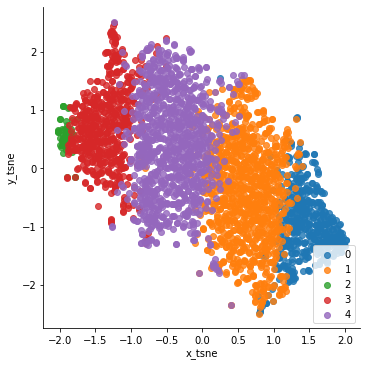

In [94]:
#Visualize Clusters
plt.figure(figsize = (12,12))

sns.lmplot(x = 'x_tsne', y = 'y_tsne', data = df_vectors, fit_reg = False, hue = 'kmeans_cluster',legend = False)

plt.legend(loc = 'lower right')

In [95]:
def tsnescatterplot(model, word, list_names, pca):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']
    proximity_score = [1.0]
    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        proximity_score.append(wrd_score[1])
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        proximity = model.wv.similarity(word, wrd)
        proximity_score.append(proximity)
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    if pca == 1:
        reduc = PCA(n_components= 0.999).fit_transform(arrays)
    else:
        reduc = arrays
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'score': proximity_score,
                       'color': color_list})
    print(df)
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

             x           y           words     score  color
0   -92.538506  -29.807034      deplorable  1.000000    red
1    32.859528  108.465134    new_hamphire  0.999890   blue
2  -108.128845 -133.278320         reality  0.999888   blue
3    66.222755   23.099525            nail  0.999887   blue
4   167.481720 -112.426865       priceless  0.999886   blue
5  -187.530502  124.092720           ecure  0.999885   blue
6   -22.918631   40.383793       leaderhip  0.999885   blue
7   264.947357  -88.069069       must_read  0.999885   blue
8     2.318594  -41.601387         comment  0.999884   blue
9    86.495811  -62.926811            core  0.999883   blue
10  124.208588 -208.251862  tucker_carlson  0.999882   blue
11  -59.236164  147.803528            hope  0.999838  green
12 -103.692375   60.536724            help  0.999840  green
13  137.187027   91.476799            hide  0.999830  green
14  229.097458 -192.843658           first  0.999804  green
15  174.703033   -3.949282            te

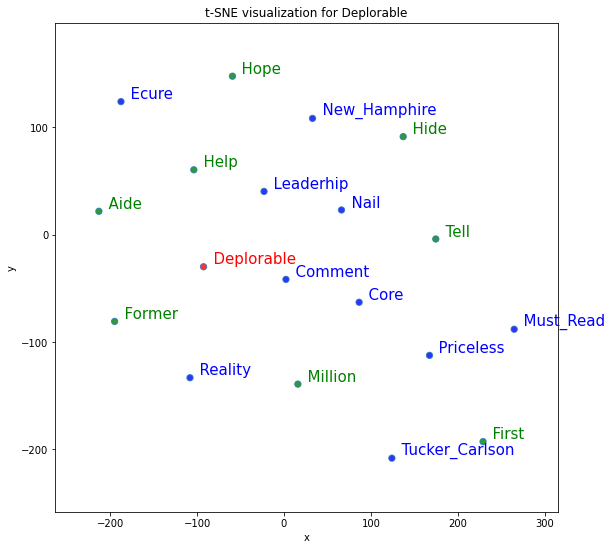

In [96]:
tsnescatterplot(model, 'deplorable', ['hope','help','hide','first','tell','former','aide','million'],1)

             x           y     words     score  color
0  -399.232880  -24.667419     swamp  1.000000    red
1   151.070679  -84.388969    bannon  0.999788   blue
2  -202.767059  -39.035645   bizarre  0.999781   blue
3    80.527885    9.283052     anwer  0.999779   blue
4   -15.564538   65.563652  politico  0.999778   blue
5  -130.568176  101.829262  upcoming  0.999776   blue
6    -0.556550 -226.738510    online  0.999775   blue
7   275.174866    1.885938    focued  0.999775   blue
8   360.919830  -94.533669      defy  0.999774   blue
9    29.802935  184.438843    appear  0.999774   blue
10 -281.785370   75.337006   gop_rep  0.999774   blue
11  230.740311 -189.560944      hope  0.999699  green
12   46.183563 -109.589920      help  0.999750  green
13  144.875778  103.819435      hide  0.999701  green
14 -275.571472 -183.830460     first  0.999648  green
15 -121.722046 -170.817215      tell  0.999733  green
16  218.303940  213.642883    former  0.999705  green
17  393.376221   67.129585  

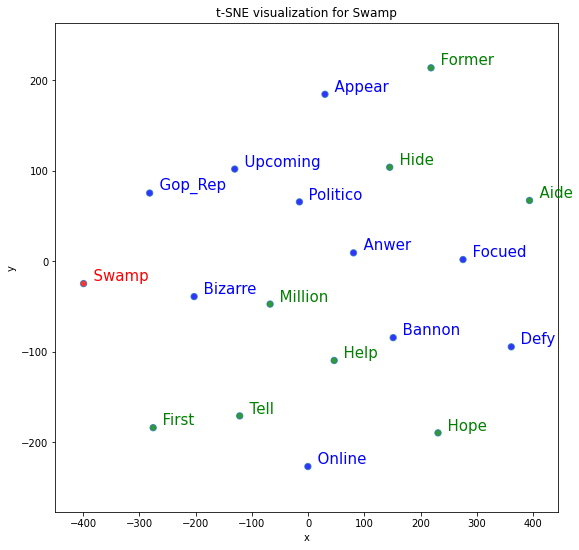

In [97]:
tsnescatterplot(model, 'swamp', ['hope','help','hide','first','tell','former','aide','million'],1)

            x           y     words     score  color
0   85.835052  108.845757   leftist  1.000000    red
1   20.640257   11.392277      brag  0.999887   blue
2   89.469810   52.194881      whoa  0.999882   blue
3  -39.168926  -89.041145      burn  0.999882   blue
4   29.396790   77.654877  liberals  0.999881   blue
5   45.784340  -57.065475    becaue  0.999881   blue
6   -4.181311  -43.024002      dead  0.999880   blue
7   74.308693   -6.388341     angry  0.999880   blue
8  -98.719971 -122.011955    viewer  0.999879   blue
9  -30.541845  126.107445       lol  0.999879   blue
10 -27.403982   54.920818      stun  0.999879   blue
11 -44.422909 -157.405136      hope  0.999808  green
12   9.492716 -113.338799      help  0.999846  green
13 -80.239960  -45.218437      hide  0.999818  green
14  33.507946  145.030487     first  0.999827  green
15 -36.169254    1.510165      tell  0.999849  green
16  15.934667 -183.835861    former  0.999765  green
17  74.452652 -148.483078      aide  0.999794 

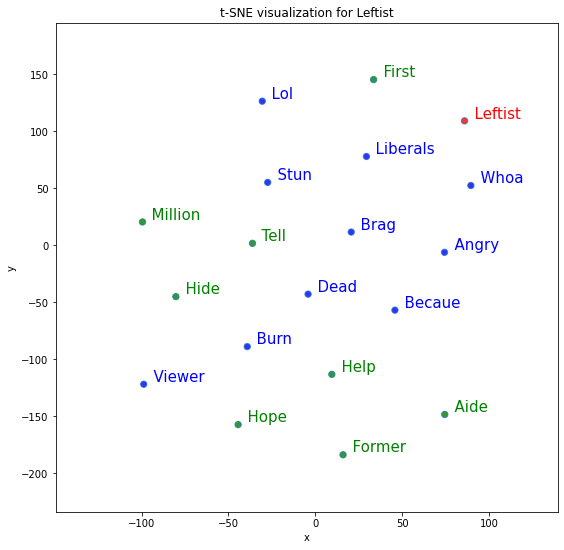

In [98]:
tsnescatterplot(model, 'leftist', ['hope','help','hide','first','tell','former','aide','million'],1)

             x           y         words     score  color
0     3.376791  104.230164        racist  1.000000    red
1    69.629555  138.082962      catholic  0.999875   blue
2    29.968525  -15.847462  nancy_pelosi  0.999873   blue
3   -61.261780  107.400101         cheat  0.999872   blue
4   -35.309452  -25.812006          view  0.999870   blue
5   -14.646458  -82.077202          love  0.999870   blue
6    47.313862  -82.057312      struggle  0.999870   blue
7    33.273125   43.104347         study  0.999870   blue
8     6.419232  177.117798      sharpton  0.999869   blue
9  -106.728149   54.490948      memorial  0.999869   blue
10  -32.091141   34.282784          maga  0.999869   blue
11  -27.221628 -156.876053          hope  0.999803  green
12   82.725243 -126.434113          help  0.999831  green
13  115.629150  -42.951633          hide  0.999816  green
14  -75.611412  181.139175         first  0.999825  green
15  100.698486   35.093147          tell  0.999834  green
16   46.003784

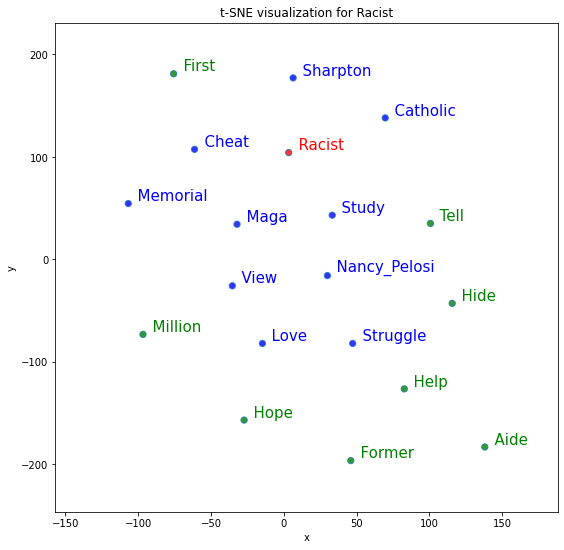

In [99]:
tsnescatterplot(model, 'racist', ['hope','help','hide','first','tell','former','aide','million'],1)

             x           y             words     score  color
0   -26.111986  373.832947     liberal_media  1.000000    red
1  -260.676147  629.335815         must_read  0.999878   blue
2  -109.202232  -21.013803           fakenew  0.999878   blue
3  -365.512451  -29.273682               mob  0.999876   blue
4    96.097176 -116.451332              turn  0.999875   blue
5  -251.595825 -227.572189            really  0.999874   blue
6   156.055283   87.330421              list  0.999872   blue
7  -233.743271  147.763031              brag  0.999871   blue
8   206.256531  300.173126              govt  0.999870   blue
9   -29.489588  177.737488             reaon  0.999870   blue
10 -259.664307  363.079651  campaign_manager  0.999869   blue
11  481.790558 -218.602005              hope  0.999788  green
12  250.946381 -279.876556              help  0.999830  green
13  -49.367405 -301.563477              hide  0.999843  green
14   48.966400  654.744751             first  0.999788  green
15 -472.

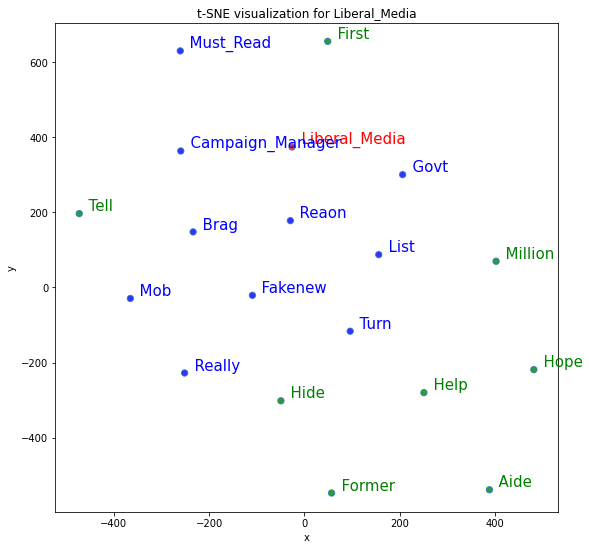

In [100]:
tsnescatterplot(model, 'liberal_media', ['hope','help','hide','first','tell','former','aide','million'],1)

             x           y             words     score  color
0   -74.401176  -62.074337     crook_hillary  1.000000    red
1   -78.396011   11.320593          opponent  0.999886   blue
2  -209.274338 -122.710815           reality  0.999886   blue
3  -123.796257 -115.720955       converation  0.999886   blue
4    64.797546  -23.790419         quetioned  0.999885   blue
5   141.354965   88.974808               guy  0.999885   blue
6    59.377563  123.126686               wow  0.999885   blue
7   -13.900246   77.249397  campaign_manager  0.999884   blue
8   -13.739530  158.042099           awesome  0.999884   blue
9    -2.693973    5.552033             treat  0.999884   blue
10  114.813705  -85.810226           explode  0.999884   blue
11 -158.845917   53.296204              hope  0.999821  green
12 -142.888199  -27.903536              help  0.999857  green
13    7.011003  -77.560921              hide  0.999859  green
14  118.319435  190.202042             first  0.999810  green
15   64.

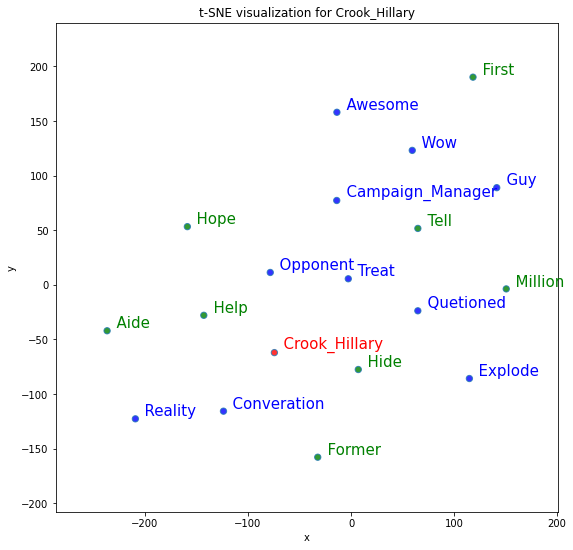

In [101]:
tsnescatterplot(model, 'crook_hillary', ['hope','help','hide','first','tell','former','aide','million'],1)

             x           y           words     score  color
0   -27.335777  183.684052   illegal_alien  1.000000    red
1    -0.220000  289.391144             nyc  0.999866   blue
2   -31.072348 -137.366348          oregon  0.999864   blue
3   122.055641  325.636169  tucker_carlson  0.999864   blue
4   170.697815  140.464951          arrest  0.999864   blue
5    81.149994 -120.672142          unreal  0.999863   blue
6    75.656059   95.084984      foundation  0.999863   blue
7   210.136551  243.837219          little  0.999863   blue
8   -27.131706   68.430763            save  0.999862   blue
9    86.111053  207.547653        year_old  0.999862   blue
10  -93.076546  -43.520206         familie  0.999862   blue
11 -222.296463  -70.651947            hope  0.999793  green
12 -133.768402 -139.783600            help  0.999845  green
13   27.837164  -30.317741            hide  0.999812  green
14  273.375061   90.802254           first  0.999810  green
15  142.753998    0.067215            te

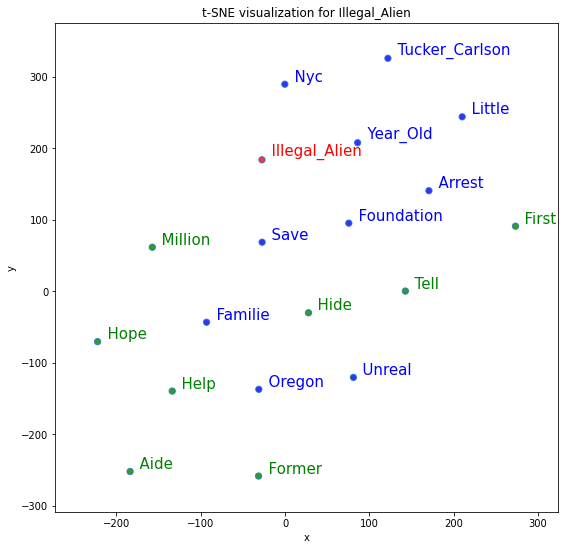

In [102]:
tsnescatterplot(model, 'illegal_alien', ['hope','help','hide','first','tell','former','aide','million'],1)

             x           y           words     score  color
0    -0.292298 -193.056442            evil  1.000000    red
1  -142.966202   36.839218      deplorable  0.999881   blue
2   141.456512   21.796051           viral  0.999880   blue
3   -33.075737  -77.363831         profeor  0.999876   blue
4   -34.838844   25.735765       apologize  0.999874   blue
5  -202.554626  113.516525          defeat  0.999874   blue
6   121.383667 -190.819244  michelle_obama  0.999873   blue
7   266.901611  -28.391939            foot  0.999873   blue
8   140.934998  -75.069809          webite  0.999872   blue
9    56.756989 -108.824013          camera  0.999872   blue
10   46.565178  -10.156902        backfire  0.999872   blue
11 -244.297302   12.137679            hope  0.999828  green
12  -85.970421  119.872643            help  0.999840  green
13   53.240353  107.571495            hide  0.999819  green
14   90.069237 -291.327332           first  0.999786  green
15  215.888336 -140.766190            te

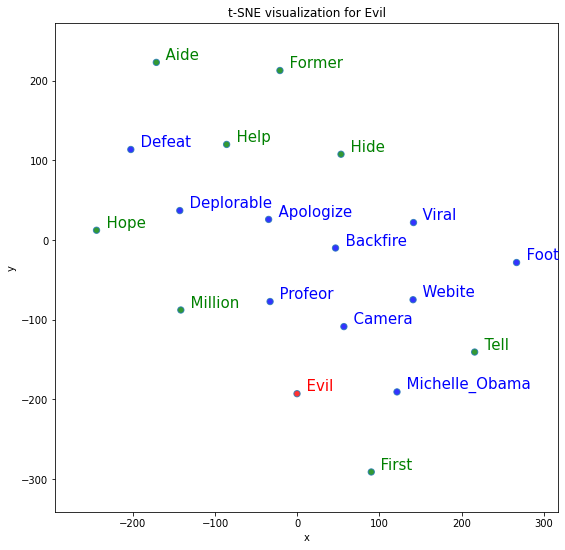

In [103]:
tsnescatterplot(model, 'evil', ['hope','help','hide','first','tell','former','aide','million'],1)

             x           y         words     score  color
0     5.608457 -115.458397    hysterical  1.000000    red
1   -10.724798  -23.520321  barack_obama  0.999887   blue
2   -18.504589   53.770050          oops  0.999882   blue
3    52.755089  106.516579       tonight  0.999879   blue
4   106.581650 -130.854218      dictator  0.999878   blue
5   -63.165504  -77.948853        camera  0.999877   blue
6  -125.749504 -133.015747       someone  0.999877   blue
7   -50.401463 -189.742996      sharpton  0.999875   blue
8    67.103333  -60.701233       awesome  0.999874   blue
9    66.768379   22.491831       profeor  0.999874   blue
10  137.475601  168.608383           bad  0.999873   blue
11   41.657356  191.306458          hope  0.999819  green
12  -25.421425  145.791077          help  0.999839  green
13  -94.190308   65.657166          hide  0.999843  green
14   45.444496 -211.090988         first  0.999806  green
15 -122.645432  -15.083023          tell  0.999847  green
16   75.516449

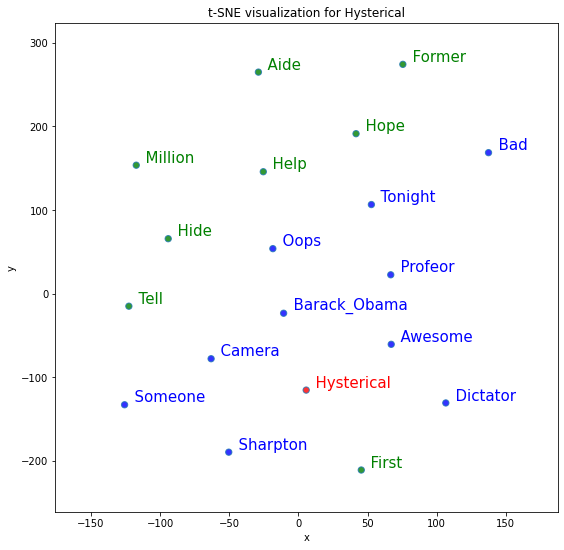

In [104]:
tsnescatterplot(model, 'hysterical', ['hope','help','hide','first','tell','former','aide','million'],1)

             x           y           words     score  color
0   -48.754093 -166.042603          commie  1.000000    red
1   179.476685  130.137802         reality  0.999888   blue
2   -86.726448  -44.919533          camera  0.999885   blue
3  -196.557159 -130.114044  tucker_carlson  0.999884   blue
4  -111.264008 -114.274948             nyc  0.999882   blue
5    11.332298  -13.880960     billionaire  0.999882   blue
6   105.231583  175.669037  preident_elect  0.999881   blue
7    97.316208   96.882736         weekend  0.999881   blue
8   -16.924595  -84.145348         totally  0.999881   blue
9    20.340340   73.700928         extreme  0.999880   blue
10 -173.763031  -49.324745         montana  0.999879   blue
11   18.376944  152.141251            hope  0.999828  green
12   79.170563   24.820440            help  0.999833  green
13  -72.391983  103.358353            hide  0.999834  green
14 -132.640350 -200.021957           first  0.999812  green
15 -128.979385   30.611423            te

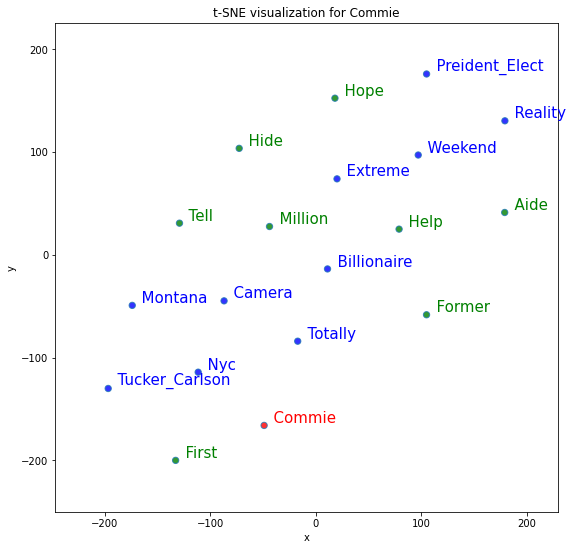

In [105]:
tsnescatterplot(model, 'commie', ['hope','help','hide','first','tell','former','aide','million'],1)

             x           y      words     score  color
0  -128.299652  106.277802      white  1.000000    red
1    54.581161  277.893494      racit  0.999836   blue
2   -59.261532   34.327381        men  0.999832   blue
3    92.588936   17.935797   proteter  0.999829   blue
4    26.886560   96.061935       thug  0.999829   blue
5    75.123688  177.945511      shoot  0.999828   blue
6   174.448486  222.974060      shirt  0.999827   blue
7    10.660229  -21.177675    liberal  0.999825   blue
8   176.383194  -37.337093  supporter  0.999824   blue
9   -41.595211 -109.815445      women  0.999823   blue
10  152.263306  102.372498        kid  0.999823   blue
11 -196.968246 -172.394547       hope  0.999697  green
12  -92.713852 -190.097656       help  0.999771  green
13   33.526527 -193.806549       hide  0.999741  green
14  -48.786839  181.124039      first  0.999758  green
15   75.823128  -97.731682       tell  0.999805  green
16  -33.163425 -287.013397     former  0.999656  green
17 -159.14

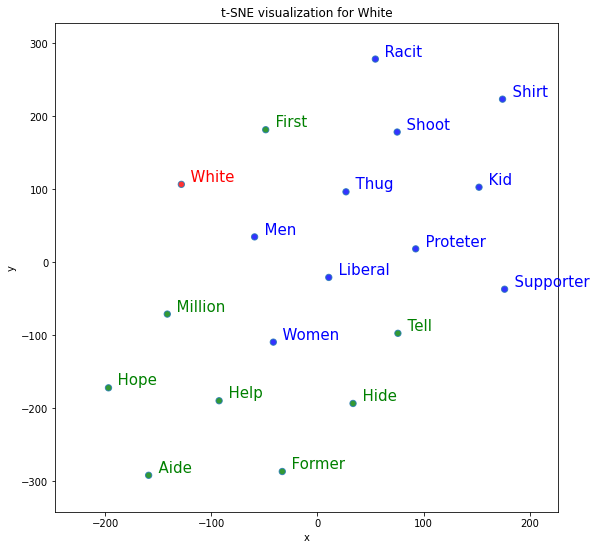

In [106]:
tsnescatterplot(model, 'white', ['hope','help','hide','first','tell','former','aide','million'],1)

             x           y          words     score  color
0   193.642960 -278.431671        corrupt  1.000000    red
1    46.343010 -136.648102       manafort  0.999835   blue
2   370.075104 -186.408752  appoint_judge  0.999828   blue
3   238.205154  -67.943916    roger_stone  0.999818   blue
4   315.254303  129.917740         indict  0.999802   blue
5  -138.688385  -82.521904       tetimony  0.999796   blue
6   106.839233   37.177933      proecutor  0.999794   blue
7   475.582336   34.311523  tucker_carlon  0.999793   blue
8   -80.438118  102.683151            toe  0.999793   blue
9  -236.667084  125.740891        mcmater  0.999792   blue
10 -105.377541 -256.269989   invetigation  0.999789   blue
11 -482.812073  118.060371           hope  0.999639  green
12 -362.058655  258.120178           help  0.999695  green
13 -303.586670  -19.565817           hide  0.999755  green
14  178.663986  325.095062          first  0.999651  green
15  -20.617096  280.023376           tell  0.999716  gre

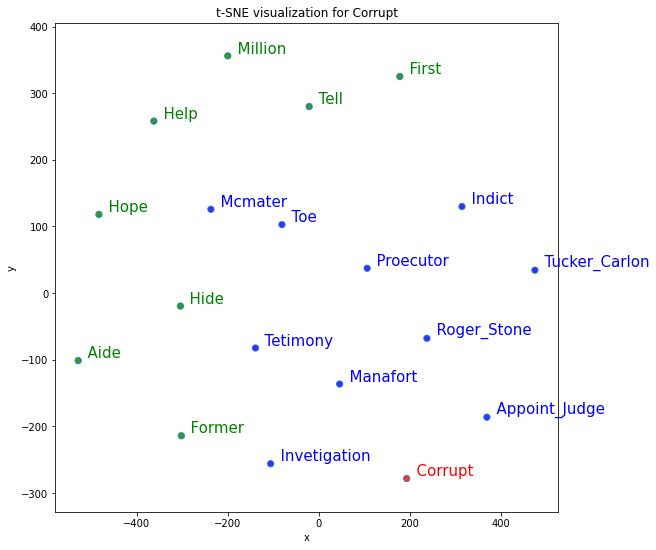

In [107]:
tsnescatterplot(model, 'corrupt', ['hope','help','hide','first','tell','former','aide','million'],1)

             x           y     words     score  color
0   -54.306736  231.274384    antifa  1.000000    red
1    80.151711  231.218262  berkeley  0.999863   blue
2   -63.832085  136.825790      thug  0.999863   blue
3    28.088428  150.127197    leftit  0.999863   blue
4    45.033470   -2.609998  proteter  0.999862   blue
5   -28.372387  -39.970142       man  0.999862   blue
6    -9.720591   57.486198   violent  0.999858   blue
7   -89.893227   33.989254    police  0.999856   blue
8   126.427490  150.455414   radical  0.999856   blue
9    12.608336  294.949432     shirt  0.999853   blue
10   83.164757   65.949509       pro  0.999852   blue
11  -11.141809 -227.524841      hope  0.999737  green
12  -43.837002 -142.021561      help  0.999802  green
13   45.002464 -107.266617      hide  0.999796  green
14  186.006393   59.901154     first  0.999769  green
15  121.303238  -48.720802      tell  0.999823  green
16   85.989273 -195.482727    former  0.999667  green
17 -113.603271 -224.833771  

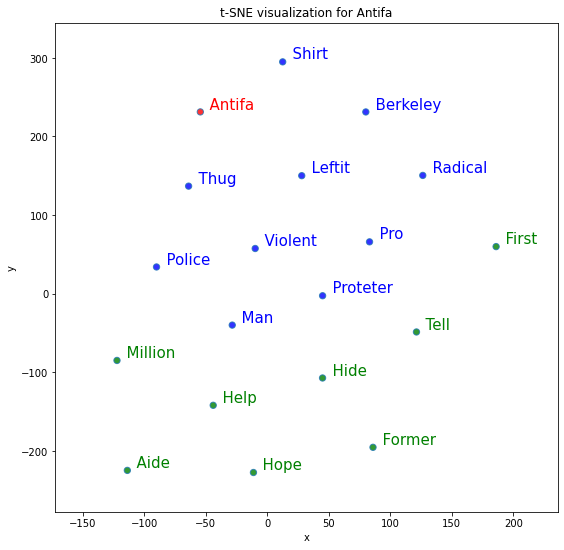

In [108]:
tsnescatterplot(model, 'antifa', ['hope','help','hide','first','tell','former','aide','million'],1)

             x           y       words     score  color
0   -36.215336  140.451935      muslim  1.000000    red
1   137.594193  -58.459419   baltimore  0.999871   blue
2  -110.862923   93.140457  foundation  0.999866   blue
3    35.867302  -77.291313        town  0.999864   blue
4  -116.866776  189.003769      barron  0.999864   blue
5    10.802936   -2.000712      becaue  0.999863   blue
6   -42.228649  239.852798      sweden  0.999862   blue
7    81.501465    5.715974       shock  0.999862   blue
8   -61.173233  -35.209835     believe  0.999861   blue
9   -43.069855   48.851318   democrats  0.999861   blue
10   32.369724   86.923904       viral  0.999861   blue
11   26.207151 -196.882797        hope  0.999794  green
12  -32.769020 -126.858749        help  0.999825  green
13  142.073029   59.013737        hide  0.999817  green
14   56.155479  189.555908       first  0.999787  green
15 -134.560974    6.886177        tell  0.999846  green
16  -72.560120 -221.156616      former  0.999750

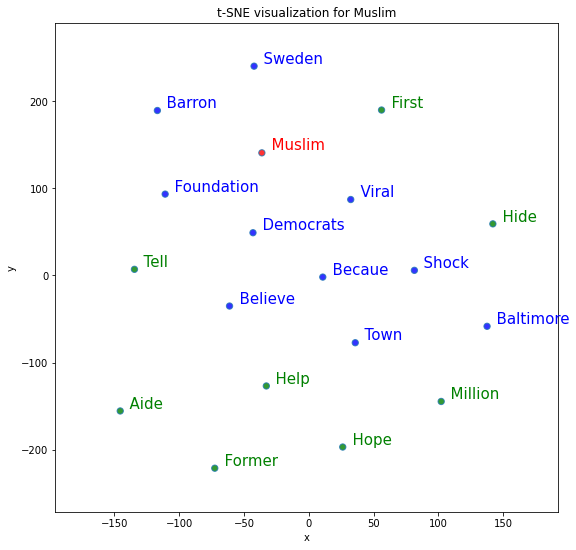

In [109]:
tsnescatterplot(model, 'muslim', ['hope','help','hide','first','tell','former','aide','million'],1)

             x           y           words     score  color
0   230.100327   34.170174      black_live  1.000000    red
1    21.763292  -80.051590        proteter  0.999705   blue
2  -156.878464  -89.547112             cop  0.999674   blue
3   -57.864002 -115.311676            thug  0.999666   blue
4    -1.096517 -196.847031        terrorit  0.999666   blue
5    12.341804   80.183479  police_officer  0.999661   blue
6  -161.126328   33.344654           black  0.999656   blue
7    27.716032    4.802461         support  0.999654   blue
8  -101.920090 -201.907013          antifa  0.999653   blue
9   -49.911968  -22.607433    conservative  0.999652   blue
10  -66.419762   56.776649          people  0.999651   blue
11   39.989311  175.155212            hope  0.999489  green
12  124.169479  150.584137            help  0.999529  green
13  104.892578   64.807175            hide  0.999545  green
14   98.780952 -139.660736           first  0.999531  green
15  106.882668  -28.457047            te

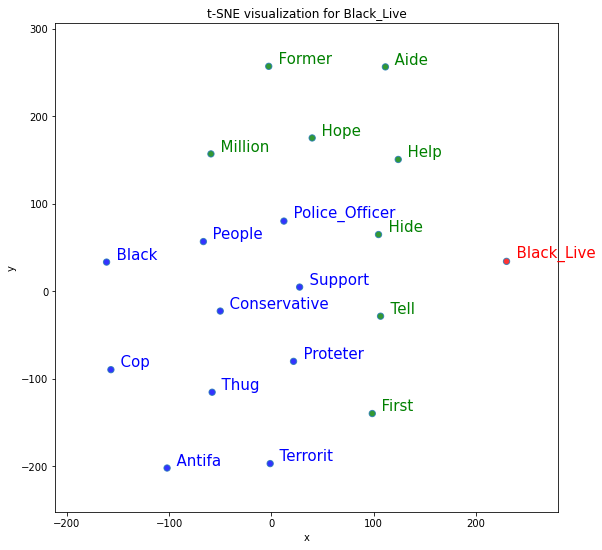

In [110]:
tsnescatterplot(model, 'black_live', ['hope','help','hide','first','tell','former','aide','million'],1)

             x           y           words     score  color
0  -124.939743 -253.869293  michelle_obama  1.000000    red
1    13.400663 -242.026993            bush  0.999879   blue
2   -55.615288 -115.192772      supporters  0.999878   blue
3   -83.493065  202.984695          oregon  0.999878   blue
4   -65.621605   40.266171    nancy_pelosi  0.999878   blue
5    46.301609  -21.754000             mob  0.999878   blue
6   105.889153 -138.605026       regitered  0.999876   blue
7   -70.043549 -415.226868           mouth  0.999875   blue
8   161.819412   46.451881        repreent  0.999875   blue
9    87.921120 -352.231873           thank  0.999875   blue
10 -175.324982  -32.391174             dog  0.999874   blue
11  289.846375  164.945084            hope  0.999807  green
12   24.039862  296.775452            help  0.999852  green
13  149.470062  225.076462            hide  0.999822  green
14  229.932449 -273.787109           first  0.999824  green
15  242.332123  -76.532478            te

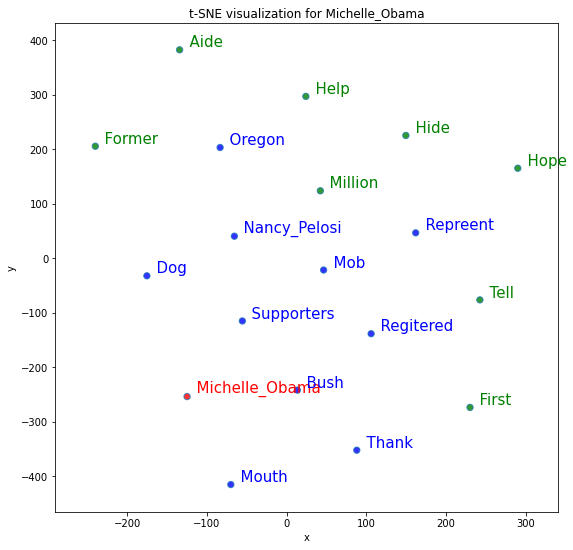

In [111]:
tsnescatterplot(model, 'michelle_obama', ['hope','help','hide','first','tell','former','aide','million'],1)

             x           y        words     score  color
0  -111.372368   16.302742    hypocrite  1.000000    red
1   107.486511   81.049347       viewer  0.999883   blue
2    47.822567   20.679268  performance  0.999882   blue
3    -5.365725   33.979935      comment  0.999880   blue
4  -174.025696   -6.185162       detroy  0.999880   blue
5    64.829811  -41.526764     canadian  0.999879   blue
6   127.577698  -53.950283      mexican  0.999879   blue
7   -52.381886   -4.843608        awful  0.999879   blue
8  -105.333488  -44.129513      explode  0.999878   blue
9  -154.553329   64.921906     sharpton  0.999878   blue
10  -76.314034   68.457664      awesome  0.999877   blue
11   40.179344   92.517647         hope  0.999812  green
12  104.122963   10.947766         help  0.999848  green
13    1.684225  -34.986454         hide  0.999832  green
14 -164.237274  -80.741364        first  0.999821  green
15  -48.585350  -81.561485         tell  0.999836  green
16  172.866379   51.860336     

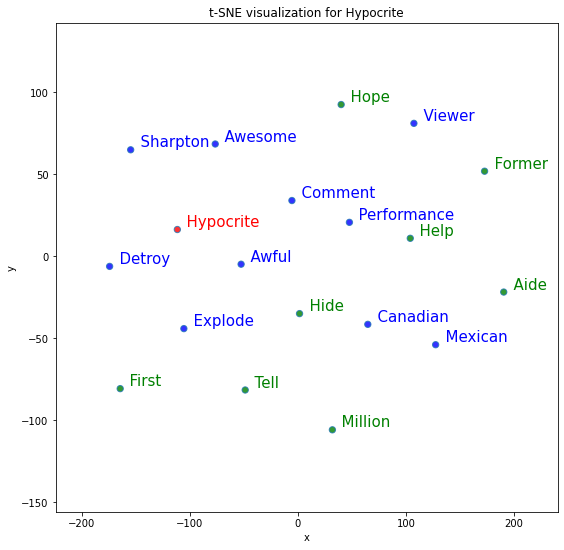

In [112]:
tsnescatterplot(model, 'hypocrite', ['hope','help','hide','first','tell','former','aide','million'],1)

             x           y         words     score  color
0    20.508709 -186.592712       destroy  1.000000    red
1   -46.182663   45.078045          stop  0.999871   blue
2  -154.412033  -78.045464  social_media  0.999866   blue
3   -30.550673  -26.679859  conservative  0.999863   blue
4    46.376888  -24.933031         shock  0.999862   blue
5  -140.059448 -160.799438      comedian  0.999861   blue
6   -48.977509 -154.534744         laugh  0.999860   blue
7   -81.555458  -95.601875          guet  0.999858   blue
8  -103.049843   -4.677787      fake_new  0.999857   blue
9     4.730770  -92.799637       liberal  0.999856   blue
10   25.670881   36.110142          oops  0.999856   blue
11   62.542965  167.222061          hope  0.999750  green
12   78.409225   87.622040          help  0.999820  green
13  114.459686    7.917221          hide  0.999840  green
14  -78.879868 -226.502441         first  0.999781  green
15   86.861046  -86.765137          tell  0.999840  green
16  147.358429

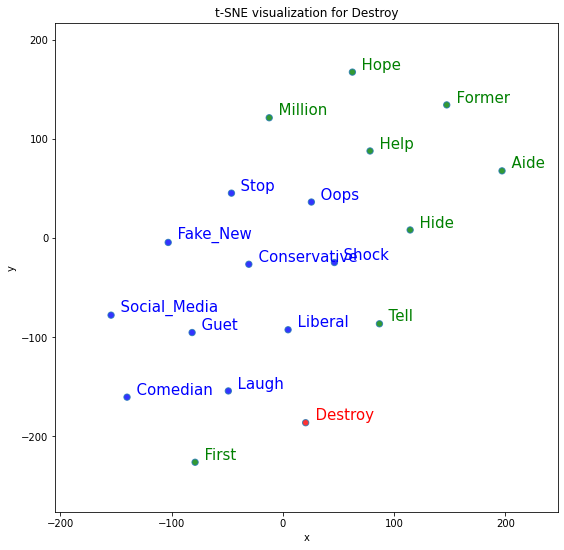

In [113]:
tsnescatterplot(model, 'destroy', ['hope','help','hide','first','tell','former','aide','million'],1)

             x           y       words     score  color
0    33.317581  -60.526485   dirty_cop  1.000000    red
1   -40.144382 -100.196953      obtain  0.999865   blue
2   -43.156879  154.181290  witch_hunt  0.999860   blue
3    -9.409965   75.509102    tetimony  0.999859   blue
4  -118.597290 -158.729462   must_read  0.999858   blue
5    25.688011 -163.495285    horowitz  0.999858   blue
6   -40.830154 -224.217850         doc  0.999854   blue
7  -106.241241   46.226799      allege  0.999854   blue
8  -125.953201  -61.641277         sue  0.999851   blue
9    51.393406   23.755472      mccabe  0.999851   blue
10 -142.481003 -261.699493    supected  0.999851   blue
11   25.963408  238.882904        hope  0.999741  green
12 -135.394974  143.126785        help  0.999803  green
13  -39.994347    0.426294        hide  0.999818  green
14  138.745789 -135.512741       first  0.999726  green
15  134.118973  -21.041876        tell  0.999804  green
16   52.839714  142.291885      former  0.999804

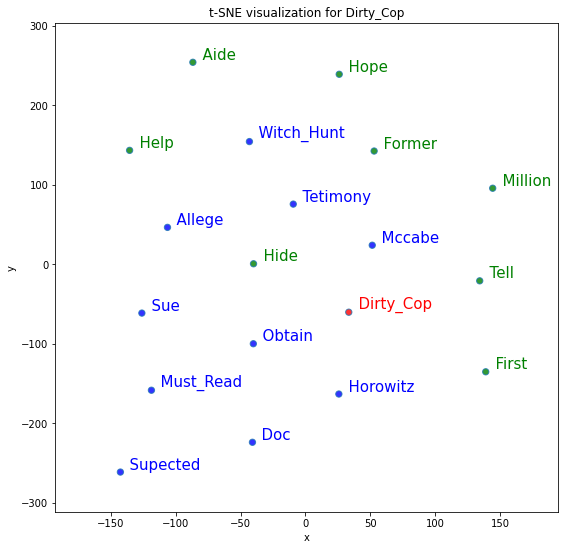

In [114]:
tsnescatterplot(model, 'dirty_cop', ['hope','help','hide','first','tell','former','aide','million'],1)

In [115]:
t = time()


arrays = np.empty((0, 300), dtype='f')
word_filters = []
word_labels = []
target_word  = []
proximity_score = []
count = 1.0
for word in model.wv.vocab:
    print(word,'||','time_now:{} mins'.format(round((time() - t) / 60, 2)),'||', '{}% Completed'.format(round(100.0 * count / float(len(model.wv.vocab)))))
    # adds the vector of the query word
    word_filters.append(word)
    word_labels.append(word)
    target_word.append(1)
    proximity_score.append(1.0)
    wrd_vector = model.wv.__getitem__([word])
    arrays = np.append(arrays, wrd_vector, axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        word_filters.append(word)
        word_labels.append(wrd_score[0])
        target_word.append(0)
        proximity_score.append(wrd_score[1])
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    count += 1
    
# Use standard scalar on word vector arrays before dimensionality reduction
# why? read: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
# arrays = StandardScaler().fit_transform(arrays)

#cluster at 300 dimensions instead of 2 dimensions for better groups, then viz at 2d

# Reduces the dimensionality from 300 to 50 dimensions/ 0.999 of variance with PCA (use multiprocesser to speed up!)
# check for cpu utilization, perform multi threading
reduc = PCA(n_components= 50).fit_transform(arrays)

# Finds t-SNE coordinates for 2 dimensions
Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))
print(arrays.shape, len(word_labels), len(target_word), len(proximity_score))

df_words = pd.DataFrame({'word_filters': word_filters,
                   'word': word_labels,
                   'x': [x for x in Y[:, 0]],
                   'y': [y for y in Y[:, 1]],
                   'is_target_word': target_word,
                   'proximity_score': proximity_score})

former || time_now:0.0 mins || 0% Completed
state_department || time_now:0.0 mins || 0% Completed
aide || time_now:0.0 mins || 0% Completed
arreted || time_now:0.0 mins || 0% Completed
connection || time_now:0.0 mins || 0% Completed
capitol_riot || time_now:0.0 mins || 0% Completed
china || time_now:0.0 mins || 0% Completed
propoe || time_now:0.0 mins || 0% Completed
change || time_now:0.0 mins || 0% Completed
hong_kong || time_now:0.0 mins || 0% Completed
electoral || time_now:0.0 mins || 0% Completed
ytem || time_now:0.0 mins || 0% Completed
biden || time_now:0.0 mins || 0% Completed
call || time_now:0.0 mins || 0% Completed
trike || time_now:0.0 mins || 0% Completed
againt || time_now:0.0 mins || 1% Completed
econd || time_now:0.0 mins || 1% Completed
target || time_now:0.0 mins || 1% Completed
syria || time_now:0.0 mins || 1% Completed
avoid || time_now:0.0 mins || 1% Completed
kill || time_now:0.0 mins || 1% Completed
official || time_now:0.0 mins || 1% Completed
impoe || time_now

expert || time_now:0.01 mins || 8% Completed
tree || time_now:0.01 mins || 8% Completed
human_right || time_now:0.01 mins || 8% Completed
king || time_now:0.01 mins || 8% Completed
report || time_now:0.01 mins || 8% Completed
releaed || time_now:0.01 mins || 8% Completed
dhs || time_now:0.01 mins || 8% Completed
grant || time_now:0.01 mins || 8% Completed
dometic || time_now:0.01 mins || 8% Completed
violent || time_now:0.01 mins || 9% Completed
extremim || time_now:0.01 mins || 9% Completed
door || time_now:0.01 mins || 9% Completed
open || time_now:0.01 mins || 9% Completed
boycott || time_now:0.01 mins || 9% Completed
grow || time_now:0.01 mins || 9% Completed
eem || time_now:0.01 mins || 9% Completed
trade_deal || time_now:0.01 mins || 9% Completed
pledge || time_now:0.01 mins || 9% Completed
agriculture || time_now:0.01 mins || 9% Completed
ecretary || time_now:0.01 mins || 9% Completed
claim || time_now:0.01 mins || 9% Completed
wrong || time_now:0.01 mins || 9% Completed
way || 

four || time_now:0.02 mins || 15% Completed
ted_cruz || time_now:0.02 mins || 15% Completed
cancun || time_now:0.02 mins || 15% Completed
trip || time_now:0.03 mins || 15% Completed
deep || time_now:0.03 mins || 15% Completed
introduce || time_now:0.03 mins || 15% Completed
weep || time_now:0.03 mins || 15% Completed
probably || time_now:0.03 mins || 15% Completed
hould || time_now:0.03 mins || 15% Completed
allow || time_now:0.03 mins || 15% Completed
ocial_media || time_now:0.03 mins || 15% Completed
gate || time_now:0.03 mins || 16% Completed
get || time_now:0.03 mins || 16% Completed
attorney || time_now:0.03 mins || 16% Completed
fbi || time_now:0.03 mins || 16% Completed
invetigating || time_now:0.03 mins || 16% Completed
handle || time_now:0.03 mins || 16% Completed
conequence || time_now:0.03 mins || 16% Completed
mohammed || time_now:0.03 mins || 16% Completed
bin || time_now:0.03 mins || 16% Completed
relationhip || time_now:0.03 mins || 16% Completed
irael || time_now:0.03 m

secretary_state || time_now:0.04 mins || 21% Completed
within || time_now:0.04 mins || 21% Completed
two || time_now:0.04 mins || 21% Completed
week || time_now:0.04 mins || 21% Completed
budget || time_now:0.04 mins || 21% Completed
work || time_now:0.04 mins || 21% Completed
might || time_now:0.04 mins || 21% Completed
edge || time_now:0.04 mins || 21% Completed
cloer || time_now:0.04 mins || 21% Completed
paue || time_now:0.04 mins || 22% Completed
becaue || time_now:0.04 mins || 22% Completed
cah || time_now:0.04 mins || 22% Completed
reform || time_now:0.04 mins || 22% Completed
protect || time_now:0.04 mins || 22% Completed
care || time_now:0.04 mins || 22% Completed
brag || time_now:0.04 mins || 22% Completed
role || time_now:0.04 mins || 22% Completed
alone || time_now:0.04 mins || 22% Completed
bitter || time_now:0.04 mins || 22% Completed
actor || time_now:0.04 mins || 22% Completed
retore || time_now:0.04 mins || 22% Completed
lead || time_now:0.04 mins || 22% Completed
dipl

fcc || time_now:0.07 mins || 27% Completed
chairman || time_now:0.07 mins || 27% Completed
repeal || time_now:0.07 mins || 27% Completed
carrier || time_now:0.07 mins || 27% Completed
empty || time_now:0.07 mins || 27% Completed
ignal || time_now:0.07 mins || 27% Completed
agree || time_now:0.07 mins || 27% Completed
mexico || time_now:0.07 mins || 28% Completed
beach || time_now:0.07 mins || 28% Completed
travel || time_now:0.07 mins || 28% Completed
requirement || time_now:0.07 mins || 28% Completed
neceary || time_now:0.07 mins || 28% Completed
article || time_now:0.07 mins || 28% Completed
etting || time_now:0.07 mins || 28% Completed
rioter || time_now:0.07 mins || 28% Completed
apologize || time_now:0.07 mins || 28% Completed
worry || time_now:0.07 mins || 28% Completed
race || time_now:0.07 mins || 28% Completed
donation || time_now:0.07 mins || 28% Completed
treaury || time_now:0.07 mins || 28% Completed
revive || time_now:0.07 mins || 28% Completed
put || time_now:0.07 mins ||

exec || time_now:0.12 mins || 33% Completed
kevin || time_now:0.12 mins || 33% Completed
carry || time_now:0.12 mins || 34% Completed
confederate || time_now:0.12 mins || 34% Completed
flag || time_now:0.12 mins || 34% Completed
racial || time_now:0.12 mins || 34% Completed
hard || time_now:0.12 mins || 34% Completed
mega || time_now:0.12 mins || 34% Completed
infratructure || time_now:0.12 mins || 34% Completed
lot || time_now:0.12 mins || 34% Completed
gop_enator || time_now:0.12 mins || 34% Completed
among || time_now:0.12 mins || 34% Completed
popular || time_now:0.12 mins || 34% Completed
tweet || time_now:0.12 mins || 34% Completed
puhed || time_now:0.12 mins || 34% Completed
voter_fraud || time_now:0.12 mins || 34% Completed
image || time_now:0.12 mins || 34% Completed
reaction || time_now:0.12 mins || 34% Completed
future || time_now:0.12 mins || 34% Completed
preent || time_now:0.12 mins || 34% Completed
debate || time_now:0.12 mins || 34% Completed
thank || time_now:0.12 mins

beg || time_now:0.18 mins || 40% Completed
ooff || time_now:0.18 mins || 40% Completed
project || time_now:0.18 mins || 40% Completed
head || time_now:0.18 mins || 40% Completed
eae || time_now:0.18 mins || 40% Completed
election_reult || time_now:0.18 mins || 40% Completed
invetment || time_now:0.18 mins || 40% Completed
raied || time_now:0.18 mins || 40% Completed
dem || time_now:0.18 mins || 40% Completed
runoff || time_now:0.18 mins || 40% Completed
crie || time_now:0.18 mins || 40% Completed
update || time_now:0.18 mins || 40% Completed
qatar || time_now:0.18 mins || 40% Completed
warnock || time_now:0.18 mins || 40% Completed
defeat || time_now:0.18 mins || 40% Completed
loeffler || time_now:0.18 mins || 40% Completed
upporting || time_now:0.18 mins || 40% Completed
koch || time_now:0.18 mins || 40% Completed
network || time_now:0.18 mins || 40% Completed
encourage || time_now:0.18 mins || 40% Completed
certify || time_now:0.18 mins || 40% Completed
undo || time_now:0.18 mins || 

brazil || time_now:0.25 mins || 45% Completed
develop || time_now:0.25 mins || 45% Completed
quetion || time_now:0.25 mins || 45% Completed
tom || time_now:0.25 mins || 46% Completed
determine || time_now:0.25 mins || 46% Completed
officially || time_now:0.25 mins || 46% Completed
appointee || time_now:0.25 mins || 46% Completed
voice || time_now:0.25 mins || 46% Completed
motion || time_now:0.25 mins || 46% Completed
north_korea || time_now:0.25 mins || 46% Completed
denuclearization || time_now:0.25 mins || 46% Completed
tank || time_now:0.25 mins || 46% Completed
gen || time_now:0.25 mins || 46% Completed
michael_flynn || time_now:0.25 mins || 46% Completed
innocent || time_now:0.25 mins || 46% Completed
jet || time_now:0.25 mins || 46% Completed
opportunity || time_now:0.25 mins || 46% Completed
wilbur || time_now:0.25 mins || 46% Completed
nominate || time_now:0.25 mins || 46% Completed
tueday || time_now:0.25 mins || 46% Completed
pack || time_now:0.25 mins || 46% Completed
final

repreent || time_now:0.33 mins || 51% Completed
gdp || time_now:0.33 mins || 51% Completed
anwer || time_now:0.33 mins || 51% Completed
will || time_now:0.33 mins || 51% Completed
liten || time_now:0.33 mins || 51% Completed
argument || time_now:0.33 mins || 51% Completed
problem || time_now:0.33 mins || 51% Completed
peronal || time_now:0.33 mins || 51% Completed
trong || time_now:0.33 mins || 52% Completed
eential || time_now:0.33 mins || 52% Completed
rnc || time_now:0.33 mins || 52% Completed
privately || time_now:0.34 mins || 52% Completed
defene_secretary || time_now:0.34 mins || 52% Completed
eper || time_now:0.34 mins || 52% Completed
ben_caron || time_now:0.34 mins || 52% Completed
china_trade || time_now:0.34 mins || 52% Completed
tenion || time_now:0.34 mins || 52% Completed
rage || time_now:0.34 mins || 52% Completed
meadow || time_now:0.34 mins || 52% Completed
teted || time_now:0.34 mins || 52% Completed
legilature || time_now:0.34 mins || 52% Completed
election_day || ti

alert || time_now:0.43 mins || 57% Completed
nancy_peloi || time_now:0.43 mins || 57% Completed
alway || time_now:0.43 mins || 57% Completed
lady || time_now:0.43 mins || 57% Completed
read || time_now:0.43 mins || 57% Completed
panel || time_now:0.43 mins || 57% Completed
apple || time_now:0.43 mins || 57% Completed
let || time_now:0.43 mins || 58% Completed
commander || time_now:0.43 mins || 58% Completed
dicuion || time_now:0.43 mins || 58% Completed
cold || time_now:0.43 mins || 58% Completed
michelle || time_now:0.43 mins || 58% Completed
boton || time_now:0.43 mins || 58% Completed
tim || time_now:0.43 mins || 58% Completed
scaramucci || time_now:0.43 mins || 58% Completed
conflict || time_now:0.43 mins || 58% Completed
flynn || time_now:0.43 mins || 58% Completed
agenda || time_now:0.44 mins || 58% Completed
caue || time_now:0.44 mins || 58% Completed
believe || time_now:0.44 mins || 58% Completed
fill || time_now:0.44 mins || 58% Completed
scalia || time_now:0.44 mins || 58% Co

organization || time_now:0.53 mins || 63% Completed
huge || time_now:0.53 mins || 63% Completed
hand || time_now:0.53 mins || 63% Completed
hundred || time_now:0.53 mins || 63% Completed
page || time_now:0.53 mins || 63% Completed
brace || time_now:0.53 mins || 63% Completed
propoed || time_now:0.53 mins || 63% Completed
client || time_now:0.53 mins || 63% Completed
glenn || time_now:0.53 mins || 64% Completed
drill || time_now:0.53 mins || 64% Completed
toll || time_now:0.53 mins || 64% Completed
inurance || time_now:0.53 mins || 64% Completed
dictator || time_now:0.53 mins || 64% Completed
warrant || time_now:0.54 mins || 64% Completed
uer || time_now:0.54 mins || 64% Completed
civil_right || time_now:0.54 mins || 64% Completed
lewi || time_now:0.54 mins || 64% Completed
warner || time_now:0.54 mins || 64% Completed
bad || time_now:0.54 mins || 64% Completed
andrew || time_now:0.54 mins || 64% Completed
income || time_now:0.54 mins || 64% Completed
wage || time_now:0.54 mins || 64% C

counter || time_now:0.63 mins || 69% Completed
behind || time_now:0.64 mins || 69% Completed
bernie || time_now:0.64 mins || 69% Completed
jimmy || time_now:0.64 mins || 69% Completed
north || time_now:0.64 mins || 69% Completed
plant || time_now:0.64 mins || 69% Completed
citie || time_now:0.64 mins || 69% Completed
penion || time_now:0.64 mins || 69% Completed
anger || time_now:0.64 mins || 69% Completed
implement || time_now:0.64 mins || 69% Completed
complicate || time_now:0.64 mins || 69% Completed
hore || time_now:0.64 mins || 69% Completed
autralia || time_now:0.64 mins || 70% Completed
diverity || time_now:0.64 mins || 70% Completed
regime || time_now:0.64 mins || 70% Completed
minneota || time_now:0.64 mins || 70% Completed
joeph || time_now:0.65 mins || 70% Completed
erupt || time_now:0.65 mins || 70% Completed
unload || time_now:0.65 mins || 70% Completed
lah || time_now:0.65 mins || 70% Completed
fake_new || time_now:0.65 mins || 70% Completed
politician || time_now:0.65 mi

KeyboardInterrupt: 

In [ ]:
wcss = []
k_size = 30
X = df_words[['x','y']]
for i in range(1,k_size):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=42)
    km.fit(X)
    wcss.append(km.inertia_)
plt.plot(range(1,k_size),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

In [ ]:
##Fitting kmeans to the dataset with k=5
km5=KMeans(n_clusters=5,init='k-means++', max_iter=300, n_init=10, random_state=42).fit(X)
word_groups = km5.labels_ 
word_groups.shape

In [ ]:
df_words['cluster_groups'] = word_groups.tolist()
df_words = df_words.sort_values(by = 'cluster_groups')

df_words.head()

In [ ]:
clusters  = df_words['cluster_groups'].unique().tolist()

for cluster in clusters:
    print('*************','cluster 1:', cluster,'*************')
    print(df_words[df_words['cluster_groups'] == cluster].head(20))

In [ ]:
# Vizualize Clusters

# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="x", y="y", data=df_words, fit_reg=False, hue='cluster_groups', legend=False)
 
# Move the legend to an empty part of the plot
plt.legend(loc='lower right')

In [ ]:
df_words.to_csv('final.csv', index = False)